# Загрузка Order book из CSV

In [83]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [84]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [85]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-09-23'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [86]:
df_history.shape

(1864605, 11)

In [87]:
df_history.sort_values('dt').head()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-09-23 00:00:01,NaN,19,binance,ETH/USDT,242.130005,0.14056,None,sell,36885590.0,disk,2018-09-23 00:00:41.7633333
2018-09-23 00:00:01,NaN,19,binance,ETH/USDT,242.139999,0.18914,None,sell,36885589.0,disk,2018-09-23 00:00:41.7633333
2018-09-23 00:00:03,NaN,19,binance,ETH/USDT,242.130005,0.27220,None,sell,36885591.0,disk,2018-09-23 00:00:41.7633333
2018-09-23 00:00:13,NaN,19,binance,ETH/USDT,242.119995,0.12910,None,buy,36885596.0,disk,2018-09-23 00:00:41.7633333
2018-09-23 00:00:13,NaN,19,binance,ETH/USDT,242.119995,0.09505,None,buy,36885592.0,disk,2018-09-23 00:00:41.7633333


In [88]:
#выбор анализируемого диапазона и группировка по минутам
df_history_period = df_history['2018-10-02 03:00':'2018-10-02 23:00'].resample('T').mean()
df_history_period.head()

,rownum,id_ex_pair,price,amount,id
dt,,,,,
2018-10-02 03:00:00,NaN,19,231.519747,0.775694,3.825204e+07
2018-10-02 03:01:00,NaN,19,231.956567,2.868537,3.825214e+07
2018-10-02 03:02:00,NaN,19,232.030737,3.254595,3.825226e+07
2018-10-02 03:03:00,NaN,19,231.950688,6.576971,3.825235e+07
2018-10-02 03:04:00,NaN,19,231.942071,6.635251,3.825243e+07


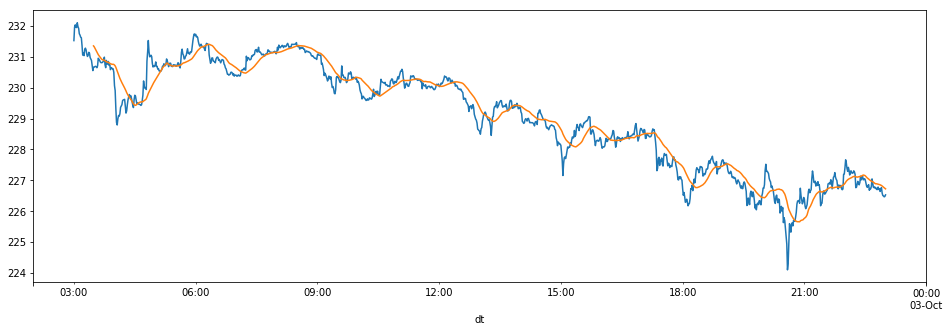

In [89]:
# выбор окна сдвига, удаление nan и график цены и скольз.среднего
window = 30

df_history_period['ma'] = df_history_period.price.rolling(window).mean()
df_history_period.ma.dropna(inplace=True)
df_history_period.price.plot()
df_history_period.ma.plot(figsize=(16,5))

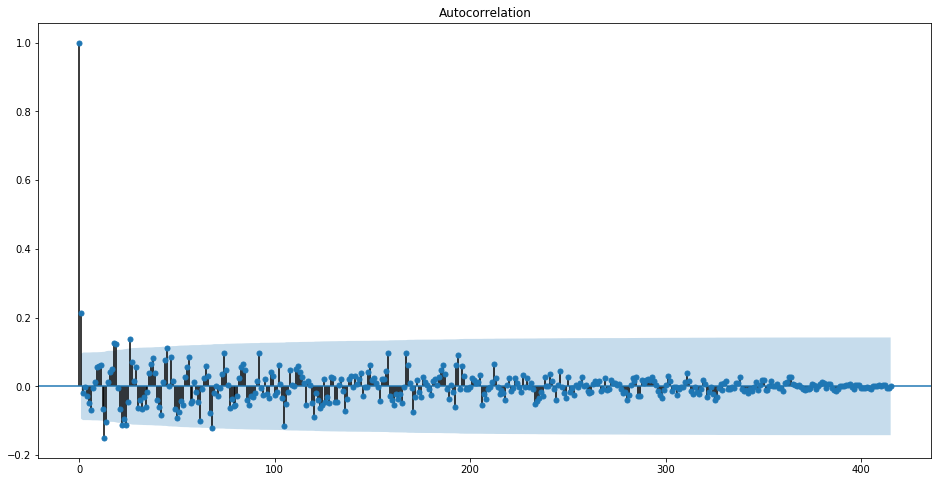

In [90]:
# детализация по часам за 8 дней
plt.rcParams['figure.figsize'] = [16, 8]
_= plot_acf(df_history.resample('H').price.mean().diff().dropna(), lags=415, alpha=0.05)

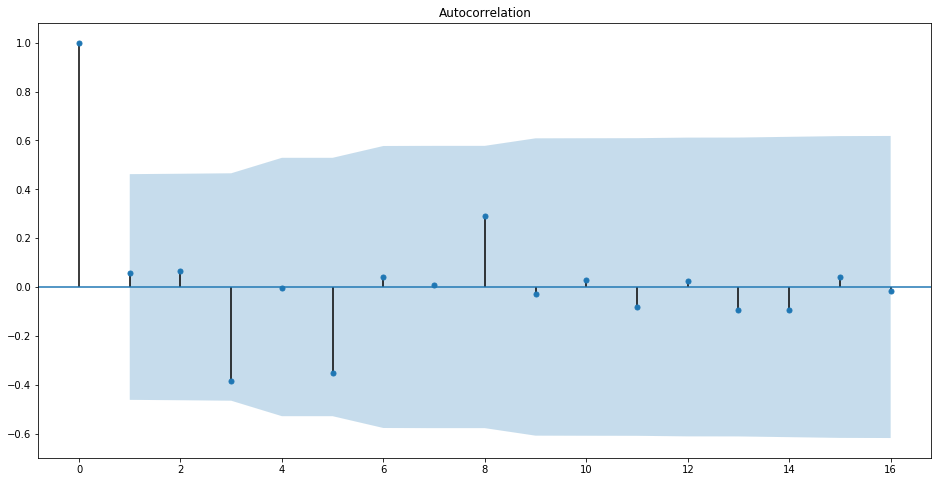

In [91]:
# детализация по дням за 7 дней
_= plot_acf(df_history.resample('D').price.mean().pct_change().dropna(), lags=16, alpha=0.05)

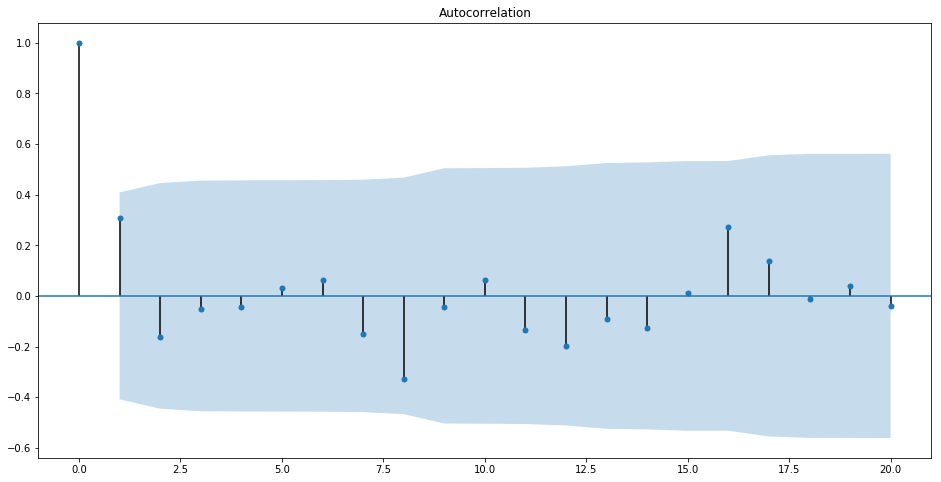

In [92]:
# детализация по часам за 1 день 3 октября

_= plot_acf(df_history['2018-10-03 00:00':'2018-10-03 23:59'].resample('H').price.mean().diff().dropna(), lags=20, alpha=0.05)

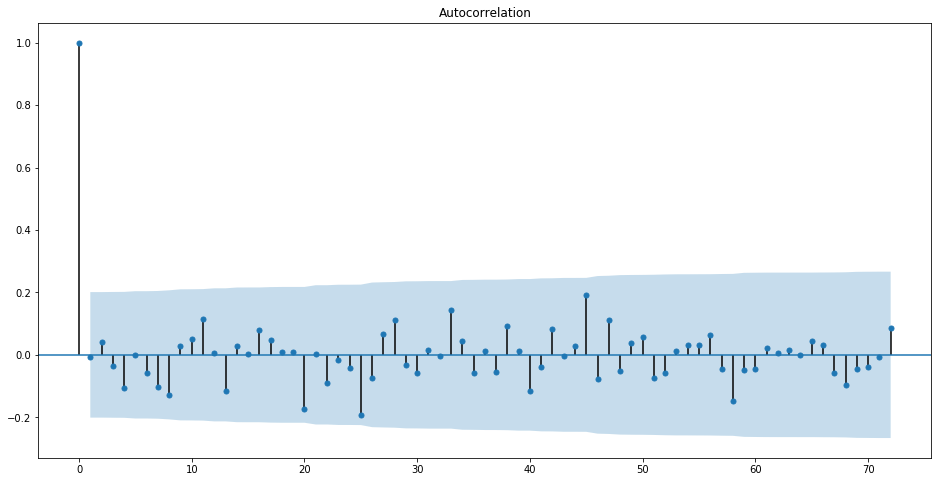

In [93]:
# детализация по часам за 3 дня 1,2,3 октября

_ = plot_acf(df_history['2018-10-03 00:00':'2018-10-06 23:59'].resample('H').price.mean().diff().dropna(), lags=72, alpha=0.05)
#plt.plot()

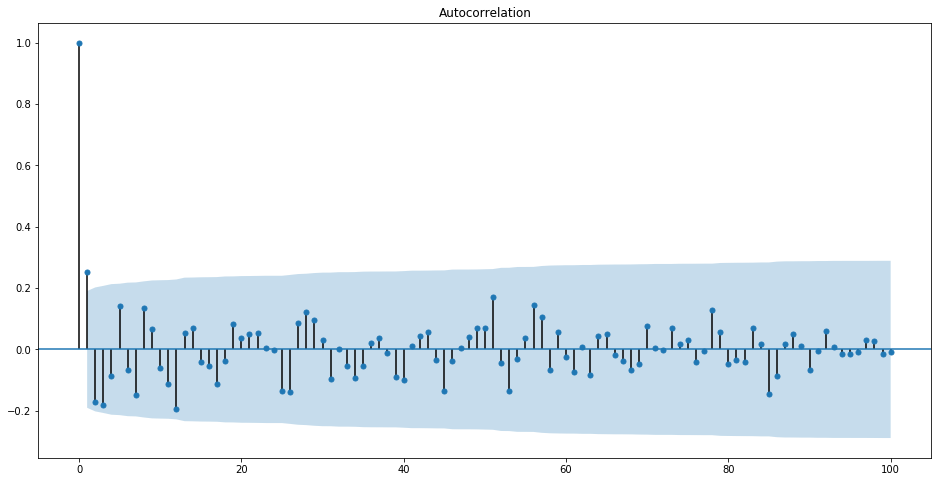

In [228]:
# детализация по минутам
_= plot_acf(df_history['2018-09-28 0:00':'2018-10-06 21:00'].resample('120min').price.mean().diff().dropna(), lags=100, alpha=0.05)

In [95]:
#_= plot_acf(df_history['2018-10-03 00:00':'2018-10-04 23:59'].resample('H').price.mean().pct_change().dropna(), lags=20, alpha=0.05)

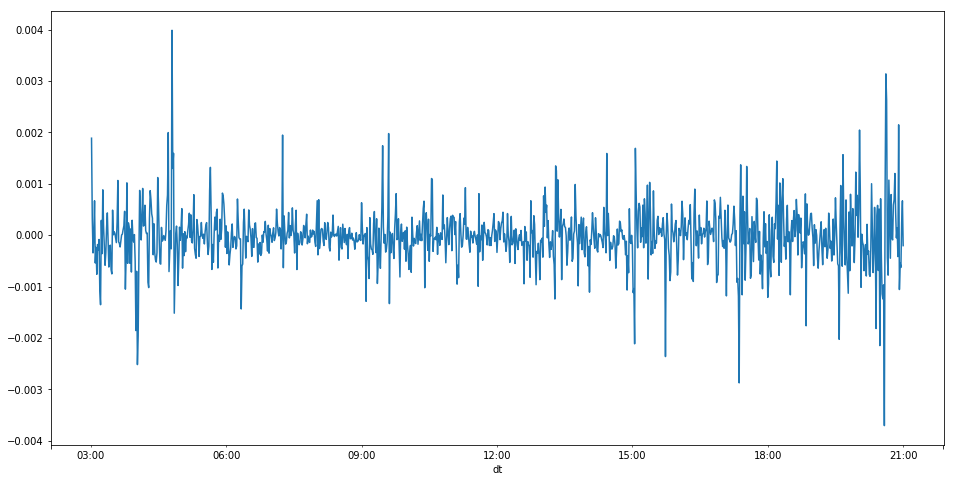

In [96]:
df_history['2018-10-02 3:00':'2018-10-02 21:00'].resample('1min').price.mean().pct_change().dropna().plot()

In [97]:
# results = adfuller(df_history['2018-10-02 3:00':'2018-10-02 21:00'].price.diff().dropna())
# print(f"p-значение для абсолютных цен равно {results[1]*100:.2f}%")

p-значение для абсолютных цен равно 0.00%


In [98]:
# results

(-45.774152698424295,
 0.0,
 69,
 105838,
 {'1%': -3.43041178743559,
  '5%': -2.861567309095109,
  '10%': -2.566784535672826},
 59941.74325298087)

In [225]:
acf(df_history['2018-09-28 0:00':'2018-10-06 21:00'].resample('120min').price.mean().pct_change().dropna(), nlags=1)[1]


0.25501853133275715

In [116]:
df_history_period = df_history['2018-09-28 0:00':'2018-10-06 21:00'].resample('1min').price.mean().reset_index().sort_values('dt')

In [226]:
#df_history = df_history['2018-09-28 0:00':'2018-10-06 21:00'].resample('1min').price.mean()
mylist = []
df_history_period['counter'] = range(len(df_history_period))
interval = 0
for interval in range(1,2000):
    df_history_period['grouper'] = df_history_period.counter // interval * interval
    pirson = acf(df_history_period.groupby('grouper').price.mean().pct_change().dropna(), nlags=1)[1]
    print ('временной интервал:', interval, 'коэффициент корреляции:', pirson)
    mylist.append(pirson)
   

временной интервал: 1 коэффициент корреляции: 0.20789497022444625
временной интервал: 2 коэффициент корреляции: 0.19157149004251683
временной интервал: 3 коэффициент корреляции: 0.21468924620349436
временной интервал: 4 коэффициент корреляции: 0.23848417674013292
временной интервал: 5 коэффициент корреляции: 0.2560116128110102
временной интервал: 6 коэффициент корреляции: 0.23656401042647918
временной интервал: 7 коэффициент корреляции: 0.24656403438118923
временной интервал: 8 коэффициент корреляции: 0.2595479782401098
временной интервал: 9 коэффициент корреляции: 0.2616772781946335
временной интервал: 10 коэффициент корреляции: 0.2282379371212805
временной интервал: 11 коэффициент корреляции: 0.23606051527035518
временной интервал: 12 коэффициент корреляции: 0.19394672685907424
временной интервал: 13 коэффициент корреляции: 0.194115635772454
временной интервал: 14 коэффициент корреляции: 0.17196608606376512
временной интервал: 15 коэффициент корреляции: 0.12883306034948097
временной 

временной интервал: 131 коэффициент корреляции: 0.18963697240499822
временной интервал: 132 коэффициент корреляции: 0.2078834958193646
временной интервал: 133 коэффициент корреляции: 0.242020529416779
временной интервал: 134 коэффициент корреляции: 0.2794274295173648
временной интервал: 135 коэффициент корреляции: 0.28713467732617326
временной интервал: 136 коэффициент корреляции: 0.20180431539389984
временной интервал: 137 коэффициент корреляции: 0.1717102586834608
временной интервал: 138 коэффициент корреляции: 0.17340041738785864
временной интервал: 139 коэффициент корреляции: 0.1924057401503986
временной интервал: 140 коэффициент корреляции: 0.22124246858842592
временной интервал: 141 коэффициент корреляции: 0.16771766046307657
временной интервал: 142 коэффициент корреляции: 0.23579114602461002
временной интервал: 143 коэффициент корреляции: 0.3008353245904931
временной интервал: 144 коэффициент корреляции: 0.27348086847156333
временной интервал: 145 коэффициент корреляции: 0.20844

временной интервал: 291 коэффициент корреляции: 0.029508002167973967
временной интервал: 292 коэффициент корреляции: -0.0013303734729892167
временной интервал: 293 коэффициент корреляции: -0.059316880911355126
временной интервал: 294 коэффициент корреляции: -0.08029853816405583
временной интервал: 295 коэффициент корреляции: -0.08636670319138517
временной интервал: 296 коэффициент корреляции: -0.07871168641550451
временной интервал: 297 коэффициент корреляции: -0.05325115810698172
временной интервал: 298 коэффициент корреляции: -0.0372435220660978
временной интервал: 299 коэффициент корреляции: -0.0186601540477826
временной интервал: 300 коэффициент корреляции: -0.016211111616345635
временной интервал: 301 коэффициент корреляции: -0.03669061554265266
временной интервал: 302 коэффициент корреляции: -0.03757068269209401
временной интервал: 303 коэффициент корреляции: -0.04717251907429293
временной интервал: 304 коэффициент корреляции: -0.04842872206789982
временной интервал: 305 коэффици

временной интервал: 438 коэффициент корреляции: 0.026298401007659886
временной интервал: 439 коэффициент корреляции: 0.019485215039126928
временной интервал: 440 коэффициент корреляции: 0.02074784699966698
временной интервал: 441 коэффициент корреляции: 0.022121903164787
временной интервал: 442 коэффициент корреляции: 0.023831759474479294
временной интервал: 443 коэффициент корреляции: 0.021430084585560855
временной интервал: 444 коэффициент корреляции: 0.028623703628290264
временной интервал: 445 коэффициент корреляции: 0.04213468095236915
временной интервал: 446 коэффициент корреляции: 0.0536931938118743
временной интервал: 447 коэффициент корреляции: 0.06542413554381718
временной интервал: 448 коэффициент корреляции: 0.08603248528057669
временной интервал: 449 коэффициент корреляции: 0.10845977261219855
временной интервал: 450 коэффициент корреляции: 0.13025990540129104
временной интервал: 451 коэффициент корреляции: 0.15933547004807225
временной интервал: 452 коэффициент корреляции

временной интервал: 566 коэффициент корреляции: 0.03482612445734467
временной интервал: 567 коэффициент корреляции: 0.033693035529967136
временной интервал: 568 коэффициент корреляции: 0.037340195617191194
временной интервал: 569 коэффициент корреляции: 0.05551675416497586
временной интервал: 570 коэффициент корреляции: 0.08111966756546388
временной интервал: 571 коэффициент корреляции: 0.10327742237411809
временной интервал: 572 коэффициент корреляции: 0.1179280714223503
временной интервал: 573 коэффициент корреляции: 0.12637318130153624
временной интервал: 574 коэффициент корреляции: 0.13048685118812153
временной интервал: 575 коэффициент корреляции: 0.1311916689728429
временной интервал: 576 коэффициент корреляции: 0.13333213557412255
временной интервал: 577 коэффициент корреляции: 0.13787263980173747
временной интервал: 578 коэффициент корреляции: 0.14802710084045817
временной интервал: 579 коэффициент корреляции: 0.1610153734633168
временной интервал: 580 коэффициент корреляции: 0

временной интервал: 730 коэффициент корреляции: -0.048645519823356145
временной интервал: 731 коэффициент корреляции: -0.04500709675837049
временной интервал: 732 коэффициент корреляции: -0.04116852790510099
временной интервал: 733 коэффициент корреляции: -0.03617402438832564
временной интервал: 734 коэффициент корреляции: -0.03178007611539024
временной интервал: 735 коэффициент корреляции: -0.027467034799277874
временной интервал: 736 коэффициент корреляции: -0.023500162594263047
временной интервал: 737 коэффициент корреляции: -0.018437990613833305
временной интервал: 738 коэффициент корреляции: -0.01389583504412516
временной интервал: 739 коэффициент корреляции: -0.0099576831952955
временной интервал: 740 коэффициент корреляции: -0.005707423848218051
временной интервал: 741 коэффициент корреляции: -0.0020557982775318948
временной интервал: 742 коэффициент корреляции: 0.0015589134710762291
временной интервал: 743 коэффициент корреляции: 0.0047995946215555136
временной интервал: 744 ко

временной интервал: 894 коэффициент корреляции: 0.049988888225087603
временной интервал: 895 коэффициент корреляции: 0.05365362221032156
временной интервал: 896 коэффициент корреляции: 0.054951721693062366
временной интервал: 897 коэффициент корреляции: 0.05457222334550702
временной интервал: 898 коэффициент корреляции: 0.05270780913773963
временной интервал: 899 коэффициент корреляции: 0.04950392700643606
временной интервал: 900 коэффициент корреляции: 0.04527794355659201
временной интервал: 901 коэффициент корреляции: 0.04179406333767441
временной интервал: 902 коэффициент корреляции: 0.03726390494799445
временной интервал: 903 коэффициент корреляции: 0.0329180858400383
временной интервал: 904 коэффициент корреляции: 0.028304168092859405
временной интервал: 905 коэффициент корреляции: 0.0234921500436034
временной интервал: 906 коэффициент корреляции: 0.018625920194595184
временной интервал: 907 коэффициент корреляции: 0.014448278780307001
временной интервал: 908 коэффициент корреляци

временной интервал: 1058 коэффициент корреляции: -0.22860123329745274
временной интервал: 1059 коэффициент корреляции: -0.22927161721407735
временной интервал: 1060 коэффициент корреляции: -0.23024187669740961
временной интервал: 1061 коэффициент корреляции: -0.23126291790764048
временной интервал: 1062 коэффициент корреляции: -0.2333348707471697
временной интервал: 1063 коэффициент корреляции: -0.226935489557158
временной интервал: 1064 коэффициент корреляции: -0.2295405334508957
временной интервал: 1065 коэффициент корреляции: -0.2326793269553926
временной интервал: 1066 коэффициент корреляции: -0.23611249794283523
временной интервал: 1067 коэффициент корреляции: -0.23925046699784688
временной интервал: 1068 коэффициент корреляции: -0.24176142426044978
временной интервал: 1069 коэффициент корреляции: -0.2443602999907451
временной интервал: 1070 коэффициент корреляции: -0.24712873939407617
временной интервал: 1071 коэффициент корреляции: -0.24938430637442985
временной интервал: 1072 к

временной интервал: 1220 коэффициент корреляции: -0.22763360332647117
временной интервал: 1221 коэффициент корреляции: -0.23389440817115256
временной интервал: 1222 коэффициент корреляции: -0.24015025076624255
временной интервал: 1223 коэффициент корреляции: -0.24517357680651553
временной интервал: 1224 коэффициент корреляции: -0.24978769202579215
временной интервал: 1225 коэффициент корреляции: -0.2545303370743229
временной интервал: 1226 коэффициент корреляции: -0.25985512607777334
временной интервал: 1227 коэффициент корреляции: -0.2643355802681279
временной интервал: 1228 коэффициент корреляции: -0.2684370191128438
временной интервал: 1229 коэффициент корреляции: -0.27292489070954057
временной интервал: 1230 коэффициент корреляции: -0.2775827031093578
временной интервал: 1231 коэффициент корреляции: -0.28198451744349684
временной интервал: 1232 коэффициент корреляции: -0.28625014386298514
временной интервал: 1233 коэффициент корреляции: -0.29029432347173456
временной интервал: 1234

временной интервал: 1384 коэффициент корреляции: -0.2228740747033867
временной интервал: 1385 коэффициент корреляции: -0.2236840117734732
временной интервал: 1386 коэффициент корреляции: -0.22449445121210934
временной интервал: 1387 коэффициент корреляции: -0.22490002207702614
временной интервал: 1388 коэффициент корреляции: -0.22542378724784337
временной интервал: 1389 коэффициент корреляции: -0.22642406633354237
временной интервал: 1390 коэффициент корреляции: -0.22700427479505736
временной интервал: 1391 коэффициент корреляции: -0.2269403720909207
временной интервал: 1392 коэффициент корреляции: -0.22681274580722524
временной интервал: 1393 коэффициент корреляции: -0.2266550530489815
временной интервал: 1394 коэффициент корреляции: -0.2263526400197494
временной интервал: 1395 коэффициент корреляции: -0.22632024548523708
временной интервал: 1396 коэффициент корреляции: -0.22641778429223888
временной интервал: 1397 коэффициент корреляции: -0.22577363009651413
временной интервал: 1398 

временной интервал: 1549 коэффициент корреляции: 0.07143351270183187
временной интервал: 1550 коэффициент корреляции: 0.07478715212809482
временной интервал: 1551 коэффициент корреляции: 0.07769111952059711
временной интервал: 1552 коэффициент корреляции: 0.08041591604030021
временной интервал: 1553 коэффициент корреляции: 0.08320073805778515
временной интервал: 1554 коэффициент корреляции: 0.08586210478468101
временной интервал: 1555 коэффициент корреляции: 0.08860595020965843
временной интервал: 1556 коэффициент корреляции: 0.09116205816690384
временной интервал: 1557 коэффициент корреляции: 0.09391843096407361
временной интервал: 1558 коэффициент корреляции: 0.09660567498128833
временной интервал: 1559 коэффициент корреляции: 0.09945924887549527
временной интервал: 1560 коэффициент корреляции: 0.10276693035424161
временной интервал: 1561 коэффициент корреляции: 0.10641574466315122
временной интервал: 1562 коэффициент корреляции: 0.1099210778724119
временной интервал: 1563 коэффициен

временной интервал: 1714 коэффициент корреляции: 0.1358213239570654
временной интервал: 1715 коэффициент корреляции: 0.1325600904555631
временной интервал: 1716 коэффициент корреляции: 0.1294094374148289
временной интервал: 1717 коэффициент корреляции: 0.12664751291036933
временной интервал: 1718 коэффициент корреляции: 0.12404796433107261
временной интервал: 1719 коэффициент корреляции: 0.1216390368919824
временной интервал: 1720 коэффициент корреляции: 0.1190529123278491
временной интервал: 1721 коэффициент корреляции: 0.11632954158305096
временной интервал: 1722 коэффициент корреляции: 0.11369592111119768
временной интервал: 1723 коэффициент корреляции: 0.11139059567479383
временной интервал: 1724 коэффициент корреляции: 0.10946432205488327
временной интервал: 1725 коэффициент корреляции: 0.10758269584689907
временной интервал: 1726 коэффициент корреляции: 0.10665925704955055
временной интервал: 1727 коэффициент корреляции: 0.10645301601481803
временной интервал: 1728 коэффициент ко

временной интервал: 1834 коэффициент корреляции: 0.1305902128728489
временной интервал: 1835 коэффициент корреляции: 0.13071549212730552
временной интервал: 1836 коэффициент корреляции: 0.13086538478400558
временной интервал: 1837 коэффициент корреляции: 0.13089934102193257
временной интервал: 1838 коэффициент корреляции: 0.13100282474783878
временной интервал: 1839 коэффициент корреляции: 0.13111237576846024
временной интервал: 1840 коэффициент корреляции: 0.1310935292645452
временной интервал: 1841 коэффициент корреляции: 0.1306981243868754
временной интервал: 1842 коэффициент корреляции: 0.13004836467338202
временной интервал: 1843 коэффициент корреляции: 0.1294524669931417
временной интервал: 1844 коэффициент корреляции: 0.12905713604851204
временной интервал: 1845 коэффициент корреляции: 0.12866981274919514
временной интервал: 1846 коэффициент корреляции: 0.12833474034530715
временной интервал: 1847 коэффициент корреляции: 0.12808328046595466
временной интервал: 1848 коэффициент к

временной интервал: 1993 коэффициент корреляции: 0.17127600760488665
временной интервал: 1994 коэффициент корреляции: 0.16993451151729314
временной интервал: 1995 коэффициент корреляции: 0.16858778201319827
временной интервал: 1996 коэффициент корреляции: 0.16727503397924584
временной интервал: 1997 коэффициент корреляции: 0.1658742757059551
временной интервал: 1998 коэффициент корреляции: 0.16442518564954317
временной интервал: 1999 коэффициент корреляции: 0.16294973574029645


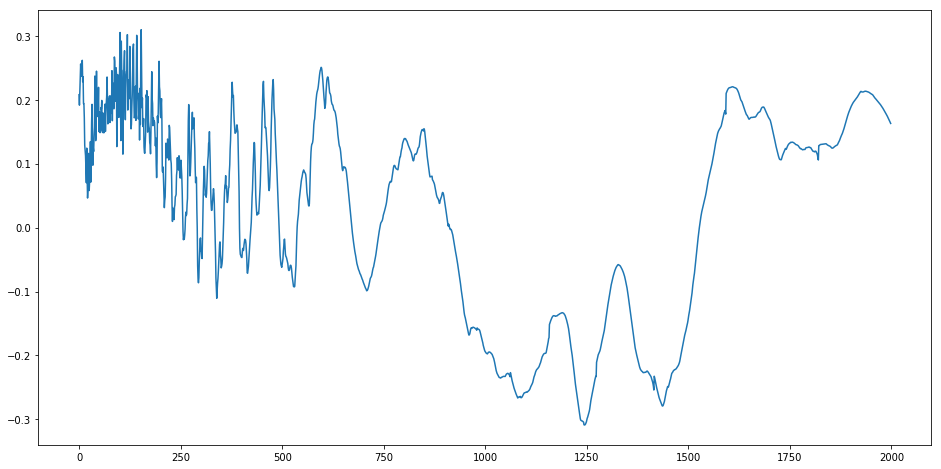

In [227]:
_= pd.Series(mylist).plot()